In [24]:
import sys

from FileTools import FileTools
# from pprint import pprint
from pathlib import Path
from zipfile import ZipFile
import pickle
#import random
import json
import time
import os

from matplotlib import pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np
import math
import re

from kaggle.api.kaggle_api_extended import KaggleApi

In [25]:
# authenticate with API

currWorkDir = os.getcwd()
userDir = Path.home()
keyPath = f"{userDir}\\PYC\\ADMIN\\kaggle.json"

with open( keyPath, 'r' ) as f: keyDict = json.load( f )
userTitle, keyTitle = keyDict.keys()
kaggleUsername, kaggleKey = keyDict[ userTitle ], keyDict[ keyTitle ]

os.environ[ 'KAGGLE_USERNAME' ] = kaggleUsername
os.environ[ 'KAGGLE_KEY' ] = kaggleKey

api = KaggleApi()
api.authenticate()


In [26]:
# retrieve dataset
datasetOwner = 'lucafrance'
datasetName = 'the-world-factbook-by-cia'
api.dataset_download_files( f'{datasetOwner}/{datasetName}', path="." )

# await download
fTools = FileTools()
datasetFName = None
print( "Waiting for dataset download" )
while True:
    time.sleep( 1 )
    sortedFs = fTools.datesortFiles( currWorkDir, datasetName )
    if len( sortedFs ) == 0: continue
    datasetFName = list( sortedFs )[ 0 ]
    print( f"Latest: {datasetFName}" )
    break

Waiting for dataset download
Latest: the-world-factbook-by-cia.zip


In [27]:
# extract and identify datafiles

origDataDir = f"{currWorkDir}\\data_or"
if not os.path.exists( origDataDir ): os.makedirs( origDataDir )

if datasetFName and Path( datasetFName ).suffix == ".zip":
    with ZipFile( datasetFName, 'r' ) as zipF: zipF.extractall( origDataDir )

dataPaths = [ f"{origDataDir}\\{pth}" for pth in os.listdir( origDataDir )
    if Path( pth ).suffix == ".csv" ]

if len( dataPaths )>0:
    dffBook = pd.read_csv( [ pth for pth in dataPaths ][ 0 ] )
    print( "Got dffBook DF from extracted dataset at:\n", dataPaths[ 0 ] )
else: print( "Failed get CSV" ); sys.exit()

dffBook

Got dffBook DF from extracted dataset at:
 C:\Users\romstroller\PYC\ciaFactBook\data_or\countries.csv


,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,https://www.cia.gov/the-world-factbook/countri...,Ahmad Shah DURRANI unified the Pashtun tribes ...,"Southern Asia, north and west of Pakistan, eas...","33 00 N, 65 00 E",Asia,"652,230 sq km","652,230 sq km",0 sq km,almost six times the size of Virginia; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,https://www.cia.gov/the-world-factbook/countri...,By terms of the 1960 Treaty of Establishment t...,"Eastern Mediterranean, peninsula on the southw...","34 37 N, 32 58 E",Middle East,123 sq km,NaN,NaN,"about 0.7 times the size of Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,https://www.cia.gov/the-world-factbook/countri...,Albania declared its independence from the Ott...,"Southeastern Europe, bordering the Adriatic Se...","41 00 N, 20 00 E",Europe,"28,748 sq km","27,398 sq km","1,350 sq km",slightly smaller than Maryland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,https://www.cia.gov/the-world-factbook/countri...,Algeria has known many empires and dynasties s...,"Northern Africa, bordering the Mediterranean S...","28 00 N, 3 00 E",Africa,"2,381,740 sq km","2,381,740 sq km",0 sq km,slightly less than 3.5 times the size of Texas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,https://www.cia.gov/the-world-factbook/countri...,Tutuila was settled by 1000 B.C. and the islan...,"Oceania, group of islands in the South Pacific...","14 20 S, 170 00 W",Oceania,224 sq km,224 sq km,0 sq km,"slightly larger than Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,https://www.cia.gov/the-world-factbook/countri...,The landlocked West Bank - the larger of the t...,"Middle East, west of Jordan, east of Israel","32 00 N, 35 15 E",Middle East,"5,860 sq km","5,640 sq km",220 sq km,slightly smaller than Delaware,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,World,https://www.cia.gov/the-world-factbook/countri...,"Globally, the 20th century was marked by: (a) ...",NaN,NaN,Physical Map of the World,510.072 million sq km,148.94 million sq km,361.9 million sq km,land area about 16 times the size of the US,...,there are 20 countries without rivers: 3 in Af...,"Caspian Sea (Azerbaijan, Iran, Kazakhstan, Rus...","the deepest lake in the world (1,620 m), and a...","Shanghai (China) - 43,303,000; Singapore (Sing...",the UN High Commissioner for Refugees (UNHCR) ...,"(44 countries) Armenia, Aruba, Azerbaijan, Bar...","(19 countries) Afghanistan, Algeria, Belarus, ...",worldwide coca cultivation in 2020 likely amou...,worldwide illicit opium poppy cultivation prob...,NaN
255,Yemen,https://www.cia.gov/the-world-factbook/countri...,The Kingdom of Yemen (colloquially known as No...,"Middle East, bordering the Arabian Sea, Gulf o...","15 00 N, 48 00 E",Middle East,"527,968 sq km","527,968 sq km",0 sq km,almost four times the size of Alabama; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16 million (2019)
256,Zambia,https://www.cia.gov/the-world-factbook/countri...,Multiple waves of Bantu-speaking groups moved ...,"Southern Africa, east of Angola, south of 

In [28]:
# Analyse cell data for numbers and units

def matchNumbers( df_in, coIdex, patrn ):
    # get any number-pattern match from each row in a list
    return df_in.iloc[ :, coIdex ].str.findall( patrn )


def getRemainder( df_in, coIdex, pattrn ):
    # store non-number remainder of string (potential unit etc)
    return df_in.iloc[ :, coIdex ].str.replace( pattrn, '' )


# MATCHING NUMBERS
# REGEX:
#   capture group             (                 
#   zero/one                  [+-]?             possible number sign
#   1-3 nums                  \d{1,3}           up to three straight nums
#   non-capture subgroup      (?:               possible thousand-groups
#     comma and 3 nums          ,\d{3}          (sep. comma)
#     zero or more times        )*              
#   non-capture subgroup      (?:               then possible decimal part
#     decimal and 1+nums        \.\d+           
#     zero/one time             )?            
#   OR (alt. to last seq)     |                 or no groups, just              
#     0+ nums, dec, 1+nums      \d*\.\d+        more nums and poss decimal
#   OR (alt. to last seq)     |             
#     1+ nums                   \d+             or just more numbers.
#   Close capture group       )
#   ( match basic number last to capture greatest valid str segment )

patt = re.compile( r'([+-]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|\d*\.\d+|\d+)' )

dfFbDict = { }  # to collect column data during cleaning
checkTypes = { }
colDex = 1
for colName in dffBook.columns[ colDex: ]:
    origCol = dffBook.iloc[ :, colDex ]
    # get match if string, store if already float, catch unexpected
    if type( origCol[ 0 ] ) == str: colDict = {
        'matchedNums': matchNumbers( dffBook, colDex, patt ),
        'remainder': getRemainder( dffBook, colDex, patt ) }
    elif type( origCol[ 0 ] ) == np.float64: colDict = {
        'matchedNums': origCol.astype( float ), 'remainder': [ ] }
    elif type( origCol[ 0 ] ) != float:
        checkTypes[ type( origCol[ 0 ] ) ] = colDex
        colDict = { 'matchedNums': origCol, 'remainder': [ ] }
    else: colDict = {
        'matchedNums': matchNumbers( dffBook, colDex, patt ),
        'remainder': getRemainder( dffBook, colDex, patt ) }
    colDict[ 'origCol' ] = origCol
    dfFbDict[ colName ] = colDict
    colDex += 1

for i in checkTypes: print( f"unexpected: {i} at {checkTypes[ i ]}" )


In [29]:
# split first match item from list as float to "clean", store else to "split"
def splitFirstOther( matchList ):
    firstVals, splitVals, checkVals = [ ], [ ], [ ]
    for mNum in range( len( matchList ) ):
        el = matchList[ mNum ]
        isFilldList = (type( el ) == list) and (len( el )>0)
        if isFilldList:  # remove any thousandcomma to support convert
            firstVals.append( float( ''.join( el[ 0 ].split( ',' ) ) ) )
            splitVals.append( [ v for v in el[ 1: ] ] )
        else:  # check all else are either nan or empty matchlist
            if ((type( el ) == list and len( el )>0) and
                (type( el ) != list and math.isnan( el ) == False)):
                checkVals.append( el )
            firstVals.append( np.nan )
            splitVals.append( np.nan )
    return firstVals, splitVals, checkVals


for colName in dfFbDict:
    colDict = dfFbDict[ colName ]
    (colDict[ 'clean' ],
    colDict[ 'splitVals' ],
    colDict[ 'checkVals' ]) = splitFirstOther( colDict[ 'matchedNums' ] )

# Raise message if got uncategorized data
for colName in dfFbDict:
    if len( dfFbDict[ colName ][ 'checkVals' ] )>0:
        print( f"Got checkvals for {colName}" )

In [30]:
# dictionary columns to DF, checking is now float
newCols = [ ]
dfFloat = dffBook.iloc[ :, 0 ]  # start with countries
for colName in dfFbDict:
    clean = pd.Series( dfFbDict[ colName ][ 'clean' ] )
    lenFloat = len( [ i for i in clean if type( i ) == float ] )
    if lenFloat>len( clean ) * 0.90:
        newCols.append( colName )
        dfFloat = pd.concat( [ dfFloat, clean ], axis=1 )
    else: print( "col is less than 90% float. Dropping..." )

dfFloat.columns = [ 'Country' ] + newCols
dfFloat


,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,NaN,174.00,NaN,33.00,NaN,"652,230.00","652,230.00",0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,NaN,196.00,NaN,34.00,NaN,123.00,NaN,NaN,0.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,NaN,191.00,NaN,41.00,NaN,"28,748.00","27,398.00","1,350.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,NaN,3.00,NaN,28.00,NaN,"2,381,740.00","2,381,740.00",0.00,3.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,NaN,100.00,NaN,14.00,NaN,224.00,224.00,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,NaN,15.00,NaN,32.00,NaN,"5,860.00","5,640.00",220.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,World,NaN,20.00,NaN,NaN,NaN,510.07,148.94,361.90,16.00,...,20.00,"372,960.00","1,620.00","43,303,000.00",202.00,44.00,19.00,202.00,"265,000.00",NaN
255,Yemen,NaN,191.00,NaN,15.00,NaN,"527,968.00","527,968.00",0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00
256,Zambia,NaN,188.00,NaN,15.00,NaN,"752,618.00","743,398.00","9,220.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Enforce non-nan threshold for rows and columns

def nanThreshold( notNan ):  # average plus .5 standard deviation (rounded)
    return int( (sum( notNan ) / len( notNan )) + 0.5 * np.std( notNan ) )


def nonNanFromDims( dfr, dim = 1 ):
    nonNans = [ ]
    for pos in range( 0, dfr.shape[ dim ] ):
        vals = (dfr.iloc[ :, pos ].tolist() if dim == 1
                else dfr.loc[ [ pos ] ].values.tolist()[ 0 ])
        
        nonNans.append( [ vals, len( [ v for v in vals
            if (type( v ) == float and not math.isnan( v )) ] ) ] )
    
    _thresh = nanThreshold( [ nval for _, nval in nonNans ] )
    keepVals = [ kval for kval, nnul in nonNans if nnul>=_thresh ]
    print( f"non-nan[ {len( keepVals )} ] thr[ {_thresh} ] dim[ {dim} ]" )
    
    return keepVals

In [32]:
# ROWS
dfRowsClean = pd.DataFrame( nonNanFromDims( dfFloat, dim=0 ) )

# add a columnindex row to track names of kept columns
dfRowsClean.loc[ -1 ] = dfFloat.columns
dfRowsClean.index = dfRowsClean.index + 1
dfRowsClean.sort_index( inplace=True )
dfRowsClean


non-nan[ 125 ] thr[ 255 ] dim[ 0 ]


,0,1,2,3,4,5,6,7,8,9,...,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053
0,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest na...,Transportation: Waterways - note 3,Transportation: Ports and terminals - top twen...,Transnational Issues: Refugees and internally ...,Transnational Issues: Trafficking in persons -...,Transnational Issues: Trafficking in persons -...,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population withou...
1,Afghanistan,NaN,174.00,NaN,33.00,NaN,"652,230.00","652,230.00",0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,NaN,191.00,NaN,41.00,NaN,"28,748.00","27,398.00","1,350.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,NaN,3.00,NaN,28.00,NaN,"2,381,740.00","2,381,740.00",0.00,3.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,NaN,14.00,NaN,12.00,NaN,"1,246,700.00","1,246,700.00",0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Venezuela,NaN,183.00,NaN,8.00,NaN,"912,050.00","882,050.00","30,000.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,Vietnam,NaN,10.00,NaN,16.00,NaN,"331,210.00","310,070.00","21,140.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Yemen,NaN,191.00,NaN,15.00,NaN,"527,968.00","527,968.00",0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00
124,Zambia,NaN,188.00,NaN,15.00,NaN,"752,618.00","743,398.00","9,220.00",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# COLS
keepCols = nonNanFromDims( dfRowsClean, dim=1 )

# convert to numeric df
dfColsClean = pd.DataFrame( { col[ 0 ]: col[ 1: ] for col in keepCols } )
df = dfColsClean.apply( pd.to_numeric, errors='ignore' )

non-nan[ 267 ] thr[ 57 ] dim[ 1 ]


In [34]:
# final type check & add countries
dTypeDict = dfColsClean.dtypes
for itemName in list( dTypeDict.keys() ):
    if dTypeDict[ itemName ] != np.float64: print( f"NOT FLOAT: {itemName}" )
dfColsClean.insert( 0, 'Country', dfRowsClean.iloc[ :, 0 ].tolist()[ 1: ] )
dfColsClean

,Country,Introduction: Background,Geography: Geographic coordinates,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Land boundaries - total,Geography: Coastline,Geography: Elevation - highest point,Geography: Elevation - lowest point,...,Transportation: Railways - standard gauge,Transportation: Merchant marine - total,Transportation: Merchant marine - by type,Transnational Issues: Refugees and internally displaced persons - stateless persons,Environment: Waste and recycling - municipal solid waste recycled annually,Environment: Waste and recycling - percent of municipal solid waste recycled,Transportation: Railways - narrow gauge,Geography: Maritime claims - exclusive economic zone,Economy: Credit ratings - Fitch rating,Military and Security: Military deployments
0,Afghanistan,174.00,33.00,"652,230.00","652,230.00",0.00,"5,987.00",0.00,"7,492.00",258.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,191.00,41.00,"28,748.00","27,398.00","1,350.00",691.00,362.00,"2,764.00",0.00,...,677.00,70.00,47.00,"1,528.00",NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,3.00,28.00,"2,381,740.00","2,381,740.00",0.00,"6,734.00",998.00,"2,908.00",-40.00,...,"2,888.00",114.00,1.00,NaN,"990,299.00",8.00,"1,085.00",NaN,NaN,NaN
3,Angola,14.00,12.00,"1,246,700.00","1,246,700.00",0.00,"5,369.00","1,600.00","2,620.00",0.00,...,NaN,54.00,13.00,NaN,NaN,NaN,"2,729.00",200.00,202.00,NaN
4,Argentina,181.00,34.00,"2,780,400.00","2,736,690.00","43,710.00","11,968.00","4,989.00","6,962.00",-105.00,...,"2,745.10",202.00,1.00,NaN,"1,074,633.00",6.00,"7,523.30",200.00,202.00,200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,Venezuela,183.00,8.00,"912,050.00","882,050.00","30,000.00","5,267.00","2,800.00","4,978.00",0.00,...,447.00,281.00,4.00,NaN,NaN,NaN,NaN,200.00,201.00,NaN
121,Vietnam,10.00,16.00,"331,210.00","310,070.00","21,140.00","4,616.00","3,444.00","3,144.00",0.00,...,178.00,"1,926.00",116.00,"30,581.00","2,201,169.00",23.00,"2,169.00",200.00,201.00,NaN
122,Yemen,191.00,15.00,"527,968.00","527,968.00",0.00,"1,601.00","1,906.00","3,666.00",0.00,...,NaN,34.00,2.00,NaN,"386,946.00",8.00,NaN,200.00,NaN,NaN
123,Zambia,188.00,15.00,"752,618.00","743,398.00","9,220.00","6,043.15",0.00,"2,330.00",329.00,...,NaN,2.00,1.00,NaN,NaN,NaN,"3,126.00",NaN,202.00,925.00


In [35]:
# Review clean DF
fbIsNa = dffBook.isna().sum().sum()
dfIsNa = dfColsClean.isna().sum().sum()
fbDim = dffBook.shape[ 0 ] * dffBook.shape[ 1 ]
dfDim = dfColsClean.shape[ 0 ] * dfColsClean.shape[ 1 ]
print( f"factbook originally shape: {dffBook.shape}" )
print( f"    NAN-density: {(fbIsNa / fbDim):.2f}% "
       f"({fbIsNa} NaN in {fbDim})" )
print( f"clean dataframe has shape: {dfColsClean.shape}" )
print( f"    NAN-density: {(dfIsNa / dfDim):.2f}% "
       f"({dfIsNa} NaN in {dfDim})" )

factbook originally shape: (258, 1054)
    NAN-density: 0.74% (200708 NaN in 271932)
clean dataframe has shape: (125, 268)
    NAN-density: 0.05% (1796 NaN in 33500)


In [36]:
# Reporting to identify any differences of unit scale within features

In [37]:
# Add some further cleaning to remainder to reduce non-unit variations

cleanReman = { }

cleanPatts = [
    r'(\([^)]*\))',  # remove all bracketed
    r'(.* m)$|(.* m) '  # remove all before " m[endline/space]" (mtn names)
    ]

for colName in list( dfColsClean.columns )[ 1: ]:
    remainder = dfFbDict[ colName ][ 'remainder' ]
    for pattStr in cleanPatts:
        patt = re.compile( pattStr )
        remainder = remainder.str.replace( patt, '' )
    cleanReman.update( { colName: remainder } )

In [38]:
# CHECK FOR SCALE FACTORS

def runScaleAnalysis( dfr, remDict ):
    colList = list( dfr.columns )
    dropFeatrs = [ ]
    cleanNotes = { }
    
    for pos in range( 1, len( colList ) ):
        colNam = colList[ pos ]
        colSeg = dfr.iloc[ :, pos ].tolist()[ :10 ]
        remndr = set( remDict[ colNam ] )
        rMainPrint = ""
        for r in list( remndr )[ :25 ]:
            if type( r ) == float: rMainPrint = rMainPrint + f"{r}\n"
            else: rMainPrint = rMainPrint + f"{r[ :60 ]}\n"
        
        report = (
            f"COL [ {pos} ] {colNam}\n\n"
            f"CLEANVALS:\n{colSeg}\n\n"
            f"REMAINDER (unq in col: {len( remndr )}):\n{rMainPrint}\n")
        
        report_a = report + "\nACCEPT(A), BREAK(B), CLEAN/SCALE NOTE(C), DROP(D)"
        report_b = report_a + "\n\nPLEASE MAKE A SELECTION:\n\n"
        usinp = input( report_a )
        while usinp not in [ 'a', 'd', 'c', 'b' ]: usinp = input( report_b )
        if usinp == 'b': break
        elif usinp == 'a': continue
        elif usinp == 'd': dropFeatrs.append( colNam )
        else: cleanNotes.update( { colNam:
            input( f"{report[ :250 ]}...\n\n\nCLEANING/SCALE NOTE" ) } )
    
    return dropFeatrs, cleanNotes

# dropFeatrs, cleanNotes = runScaleAnalysis(dfColsClean, cleanReman)

In [39]:
# # SAVE SCALE ANALYSIS DATA
# stmp = fTools.dtStamp()
# fTools.storePKL( dropFeatrs, f'dropFeatrs_{stmp}', currWorkDir, subdir=None )
# fTools.storePKL( cleanNotes, f'cleanNotes_{stmp}', currWorkDir, subdir=None )

In [40]:
# LOAD SCALE ANALYSIS DATA
pklFiles = [ fi for fi in [ open( pth, 'rb' )
    for pth in [ list( dKey )[ 0 ]
        for dKey in [ fTools.datesortFiles( currWorkDir, fNam )
            for fNam in [ 'dropFeatrs', 'cleanNotes' ]
            ] ] ] ]

dropFeats, scaleNotes = [ pickle.load( fi ) for fi in pklFiles ]
for fi in pklFiles: fi.close()

In [41]:
df = dfColsClean.copy()
df.drop( dropFeats, axis=1, inplace=True )
scaleKeys = [ dkey for dkey in scaleNotes if dkey not in dropFeats ]
df


,Country,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Land boundaries - total,Geography: Coastline,Geography: Elevation - highest point,Geography: Elevation - lowest point,Geography: Elevation - mean elevation,Geography: Land use - agricultural land,...,Transportation: Roadways - unpaved,Military and Security: Military expenditures,Military and Security: Military and security service personnel strengths,Transportation: Railways - total,Transportation: Railways - standard gauge,Transportation: Merchant marine - total,Transnational Issues: Refugees and internally displaced persons - stateless persons,Environment: Waste and recycling - municipal solid waste recycled annually,Environment: Waste and recycling - percent of municipal solid waste recycled,Transportation: Railways - narrow gauge
0,Afghanistan,"652,230.00","652,230.00",0.00,"5,987.00",0.00,"7,492.00",258.00,"1,884.00",58.10,...,"17,000.00",3.30,"58,000.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,"28,748.00","27,398.00","1,350.00",691.00,362.00,"2,764.00",0.00,708.00,42.80,...,NaN,1.40,"8,000.00",677.00,677.00,70.00,"1,528.00",NaN,NaN,NaN
2,Algeria,"2,381,740.00","2,381,740.00",0.00,"6,734.00",998.00,"2,908.00",-40.00,800.00,17.40,...,"32,344.00",5.60,"140,000.00","3,973.00","2,888.00",114.00,NaN,"990,299.00",8.00,"1,085.00"
3,Angola,"1,246,700.00","1,246,700.00",0.00,"5,369.00","1,600.00","2,620.00",0.00,"1,112.00",45.70,...,"12,400.00",1.40,"101,000.00","2,852.00",NaN,54.00,NaN,NaN,NaN,"2,729.00"
4,Argentina,"2,780,400.00","2,736,690.00","43,710.00","11,968.00","4,989.00","6,962.00",-105.00,595.00,53.90,...,"163,674.00",0.80,"82,000.00","36,917.40","2,745.10",202.00,NaN,"1,074,633.00",6.00,"7,523.30"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,Venezuela,"912,050.00","882,050.00","30,000.00","5,267.00","2,800.00","4,978.00",0.00,450.00,24.50,...,NaN,5.20,125.00,447.00,447.00,281.00,NaN,NaN,NaN,NaN
121,Vietnam,"331,210.00","310,070.00","21,140.00","4,616.00","3,444.00","3,144.00",0.00,398.00,34.80,...,"47,130.00",2.40,"470,000.00","2,600.00",178.00,"1,926.00","30,581.00","2,201,169.00",23.00,"2,169.00"
122,Yemen,"527,968.00","527,968.00",0.00,"1,601.00","1,906.00","3,666.00",0.00,999.00,44.50,...,"65,100.00",4.00,"300,000.00",NaN,NaN,34.00,NaN,"386,946.00",8.00,NaN
123,Zambia,"752,618.00","743,398.00","9,220.00","6,043.15",0.00,"2,330.00",329.00,"1,138.00",31.70,...,"52,783.00",1.30,"17,000.00","3,126.00",NaN,2.00,NaN,NaN,NaN,"3,126.00"


In [42]:
# update value by matching remainder scale fragment via country reference

dct = dfFbDict.copy()

scaleDict = {
    "million": 1000000,
    "billion": 1000000000,
    "trillion": 1000000000000 }

cleanCountries = list( df[ 'Country' ] )

for colName in scaleKeys:
    colVals = [ ]
    row = 0
    
    # checking remnantcol (HAS PRE-CLEAN ENTRIES) for match
    for remnt in dct[ colName ][ 'remainder' ]:
        country = dffBook[ 'Country' ][ row ]
        if country not in cleanCountries: row += 1; continue
        val = df.loc[ df[ 'Country' ] == country ][ colName ].iloc[ 0 ]
        if type( remnt ) == float: row += 1; colVals.append( val ); continue
        
        if remnt.startswith( "-$" ): val = 0 - val  # fix $ breaking neg float
        
        matches = [ ]
        for scale in scaleDict:  # apply lowest-index matched scale
            try: matches.append( [ remnt.index( scale ), scale ] )
            except ValueError: continue
        
        if len( matches )>0:  # sort by lowest index (first val of match)
            matchScale = sorted( matches, key=lambda x: x[ 0 ] )[ 0 ][ 1 ]
            val = val * scaleDict[ matchScale ]
        colVals.append( val )
        row += 1
    
    df[ colName ] = colVals

In [43]:
pd.options.display.float_format = '{:,.2f}'.format
df


,Country,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Land boundaries - total,Geography: Coastline,Geography: Elevation - highest point,Geography: Elevation - lowest point,Geography: Elevation - mean elevation,Geography: Land use - agricultural land,...,Transportation: Roadways - unpaved,Military and Security: Military expenditures,Military and Security: Military and security service personnel strengths,Transportation: Railways - total,Transportation: Railways - standard gauge,Transportation: Merchant marine - total,Transnational Issues: Refugees and internally displaced persons - stateless persons,Environment: Waste and recycling - municipal solid waste recycled annually,Environment: Waste and recycling - percent of municipal solid waste recycled,Transportation: Railways - narrow gauge
0,Afghanistan,"652,230.00","652,230.00",0.00,"5,987.00",0.00,"7,492.00",258.00,"1,884.00",58.10,...,"17,000.00",3.30,"58,000.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,"28,748.00","27,398.00","1,350.00",691.00,362.00,"2,764.00",0.00,708.00,42.80,...,NaN,1.40,"8,000.00",677.00,677.00,70.00,"1,528.00",NaN,NaN,NaN
2,Algeria,"2,381,740.00","2,381,740.00",0.00,"6,734.00",998.00,"2,908.00",-40.00,800.00,17.40,...,"32,344.00",5.60,"140,000.00","3,973.00","2,888.00",114.00,NaN,"990,299.00",8.00,"1,085.00"
3,Angola,"1,246,700.00","1,246,700.00",0.00,"5,369.00","1,600.00","2,620.00",0.00,"1,112.00",45.70,...,"12,400.00",1.40,"101,000.00","2,852.00",NaN,54.00,NaN,NaN,NaN,"2,729.00"
4,Argentina,"2,780,400.00","2,736,690.00","43,710.00","11,968.00","4,989.00","6,962.00",-105.00,595.00,53.90,...,"163,674.00",0.80,"82,000.00","36,917.40","2,745.10",202.00,NaN,"1,074,633.00",6.00,"7,523.30"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,Venezuela,"912,050.00","882,050.00","30,000.00","5,267.00","2,800.00","4,978.00",0.00,450.00,24.50,...,NaN,5.20,125.00,447.00,447.00,281.00,NaN,NaN,NaN,NaN
121,Vietnam,"331,210.00","310,070.00","21,140.00","4,616.00","3,444.00","3,144.00",0.00,398.00,34.80,...,"47,130.00",2.40,"470,000.00","2,600.00",178.00,"1,926.00","30,581.00","2,201,169.00",23.00,"2,169.00"
122,Yemen,"527,968.00","527,968.00",0.00,"1,601.00","1,906.00","3,666.00",0.00,999.00,44.50,...,"65,100.00",4.00,"300,000.00",NaN,NaN,34.00,NaN,"386,946.00",8.00,NaN
123,Zambia,"752,618.00","743,398.00","9,220.00","6,043.15",0.00,"2,330.00",329.00,"1,138.00",31.70,...,"52,783.00",1.30,"17,000.00","3,126.00",NaN,2.00,NaN,NaN,NaN,"3,126.00"


In [44]:
# a few top-tens

In [60]:
# need to go back and get units
def showTopTen( featName ):
    print( featName )
    
    df10 = pd.concat( [ df[ 'Country' ], pd.Series( df[ featName ] ) ],
        axis=1 ).sort_values( by=[ featName ], ascending=False )[ :10 ]
    
    fig = plt.figure()
    fig.suptitle( "TOP TEN:\n" + featName, fontsize=10 )
    
    ax = fig.add_axes( [ 0, 0, 1, 1 ] )
    ax.bar( df10.iloc[ :, 0 ], df10.iloc[ :, 1 ] )
    ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )
    ax.ticklabel_format( axis='y', useOffset=False, style='plain' )
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize( 14 )
    plt.show()


Geography: Area - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


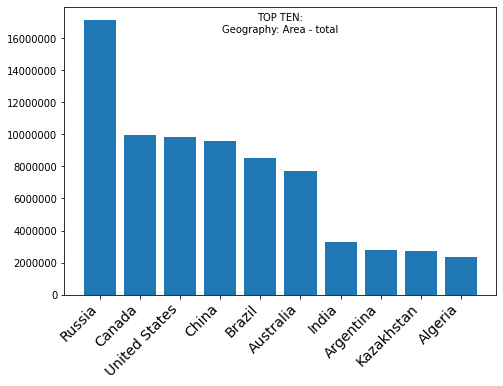

Water-area ratio


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


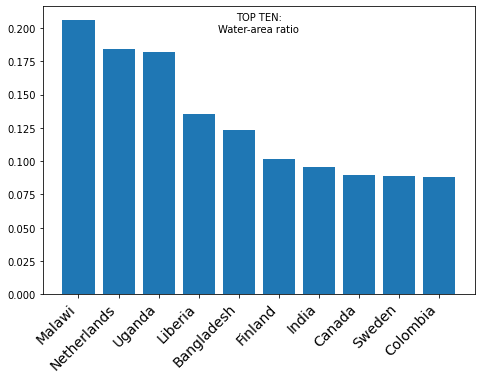

Geography: Coastline


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


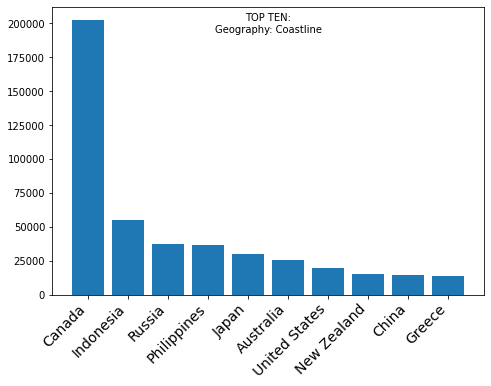

Elevation difference


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


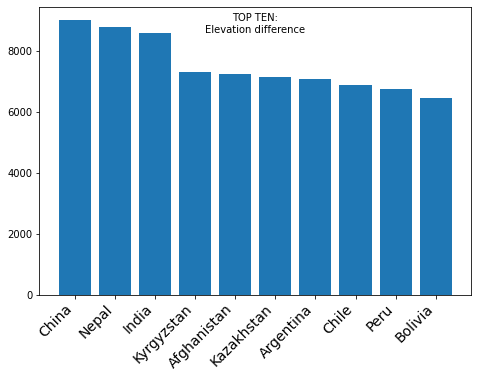

People and Society: Age structure - 65 years and over


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


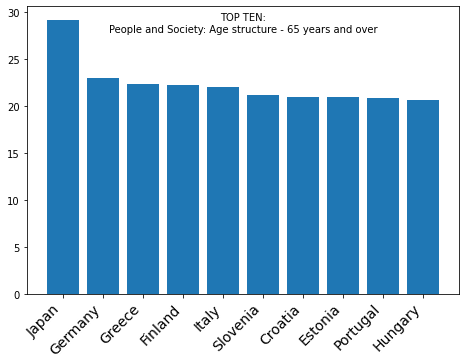

People and Society: Median age - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


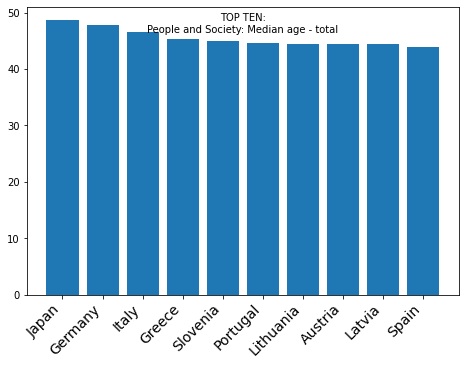

People and Society: Sex ratio - 55-64 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


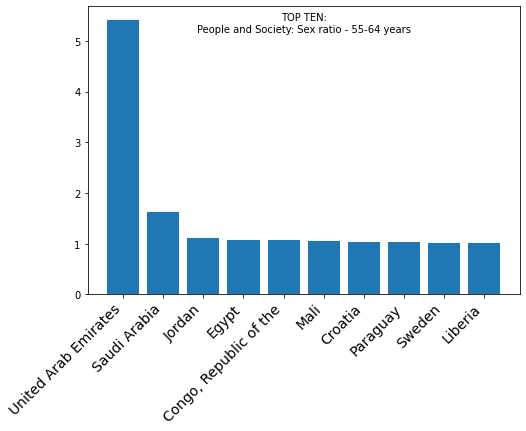

People and Society: Age structure - 25-54 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


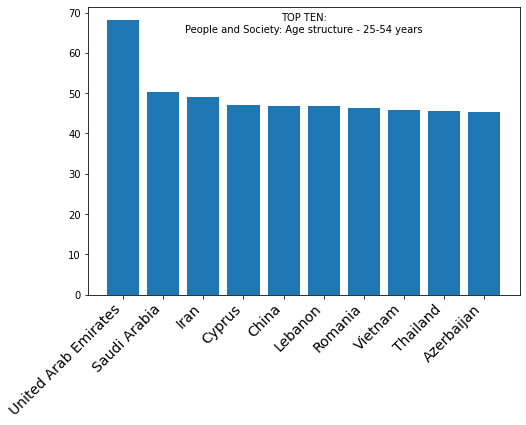

People and Society: Dependency ratios - potential support ratio


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


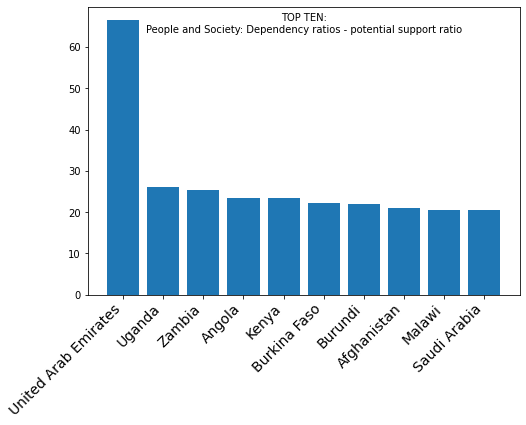

Irrigated-area ratio


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


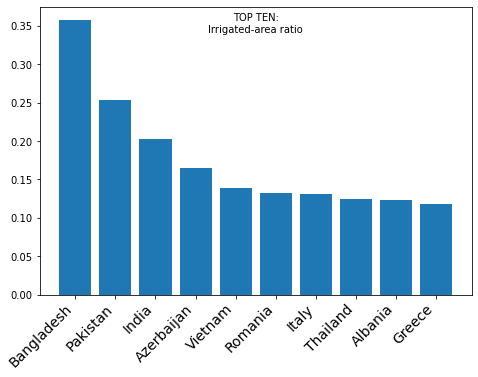

In [65]:
# largest countries. 
showTopTen( 'Geography: Area - total' )
# Some thoughts:
#   The invasion of Ukraine should not be considered an act of claustrophobia
#   Looking at sovereign territories as real-estate for future resources [..]
#   ...

# highest percent water area
df[ 'Water-area ratio' ] = (
    df[ 'Geography: Area - water' ] /
    df[ 'Geography: Area - total' ])
showTopTen( 'Water-area ratio' )

# It should be safe to posit that Canada is likely at least somewhat well-known 
# as a destination for those people with metal detectors you always see a few 
# hundred meters away at the beach.
showTopTen( 'Geography: Coastline' )

# greatest height from lowest point
# China may not have as high a mountain as Sagarmatha(?), but a hypothetical 
# mountain from its lowest to heighest elevation would dwarf it. 
df[ 'Elevation difference' ] = (
    df[ 'Geography: Elevation - highest point' ] -
    df[ 'Geography: Elevation - lowest point' ])
showTopTen( 'Elevation difference' )

# highest percent of population in the 65+ bracket (Japan by far)
showTopTen( 'People and Society: Age structure - 65 years and over' )
# Noting that, while Japan retains the lead, the difference is far less stark
# in terms of median age
showTopTen( 'People and Society: Median age - total' )

# UAE's men-to-women ratio in the 55-64yo is startlingly the most weighted to 
# the former
showTopTen( 'People and Society: Sex ratio - 55-64 years' )
# While at the same time, has (by good measure) the highest value for
# the percentage of total population that is in 25-54 years old.
showTopTen( 'People and Society: Age structure - 25-54 years' )
# Interesting combination - purely speculating, one can imagine a dominating
# social discourse might concern the relation of older men to working-age adults.
# This consideration is furnished with the dependency ratio, in which
# UAE is by very, very far the the world chart-topper:
showTopTen( 'People and Society: Dependency ratios - potential support ratio' )
# (What is the DR, and how would these three figures relate?)

# Ratio of irrigated land to total land
df[ 'Irrigated-area ratio' ] = (
    df[ 'Geography: Irrigated land' ] /
    df[ 'Geography: Area - total' ])
showTopTen( 'Irrigated-area ratio' )

Geography: Area - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


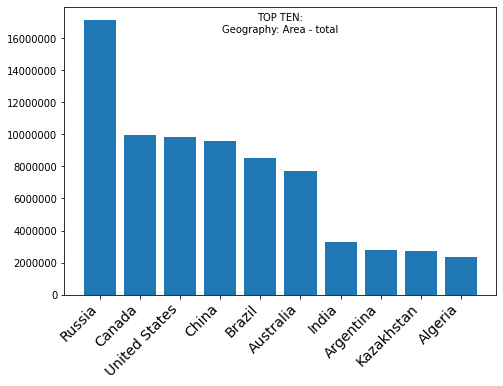

Geography: Area - land


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


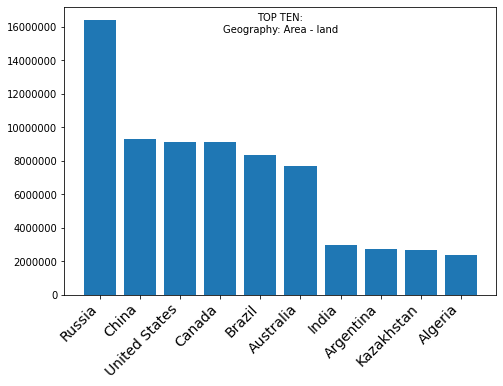

Geography: Area - water


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


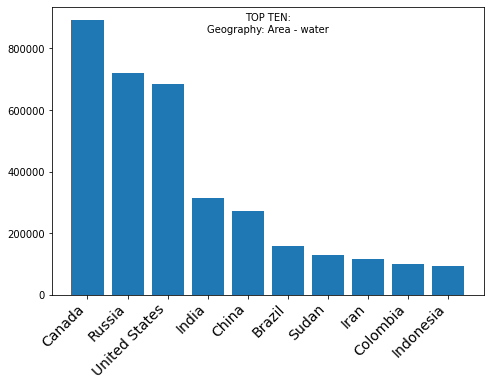

Geography: Land boundaries - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


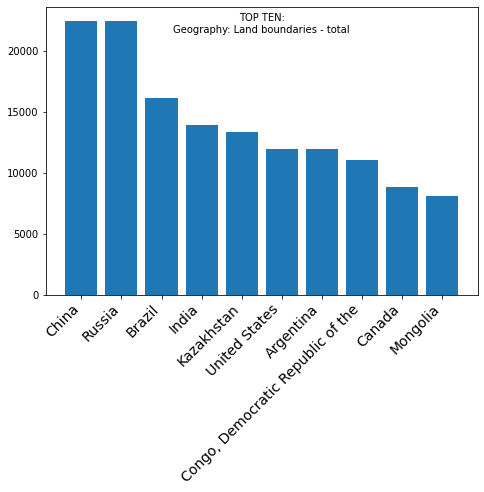

Geography: Coastline


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


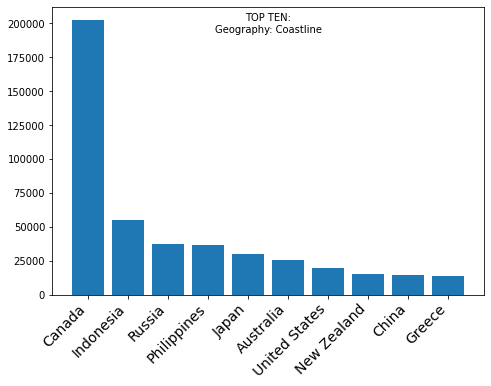

Geography: Elevation - highest point


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


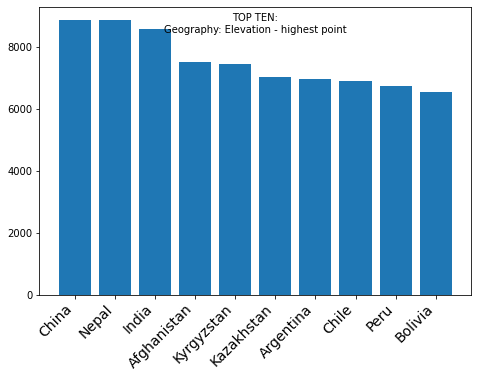

Geography: Elevation - lowest point


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


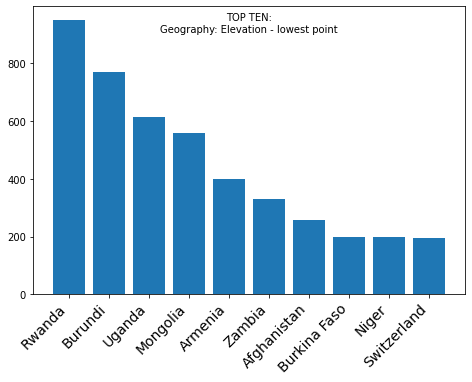

Geography: Elevation - mean elevation


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


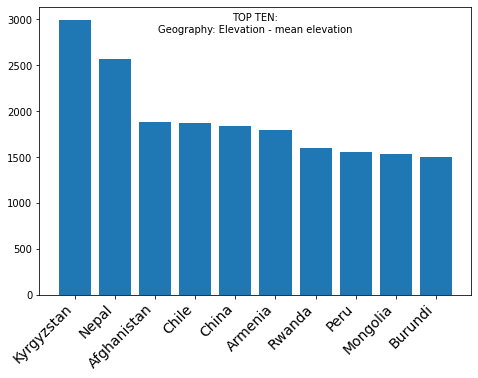

Geography: Land use - agricultural land


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


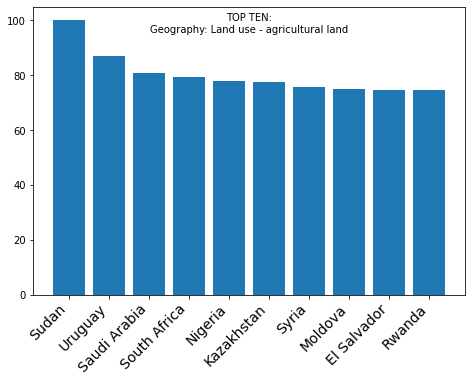

Geography: Land use - forest


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


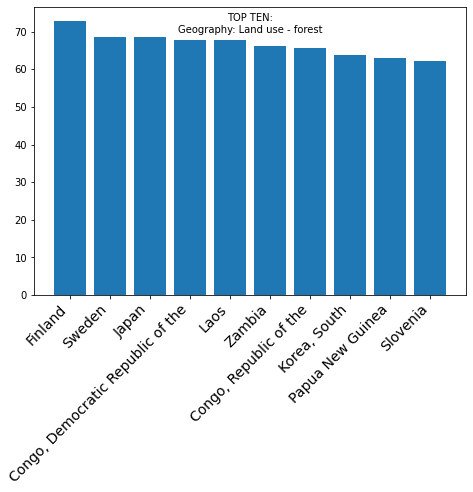

Geography: Land use - other


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


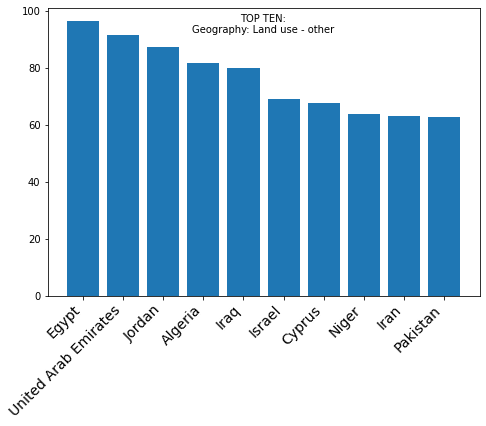

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


Geography: Irrigated land


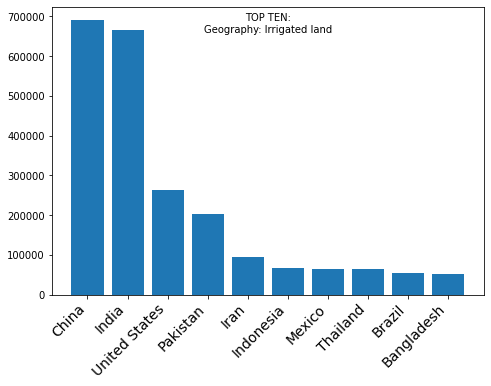

People and Society: Population


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


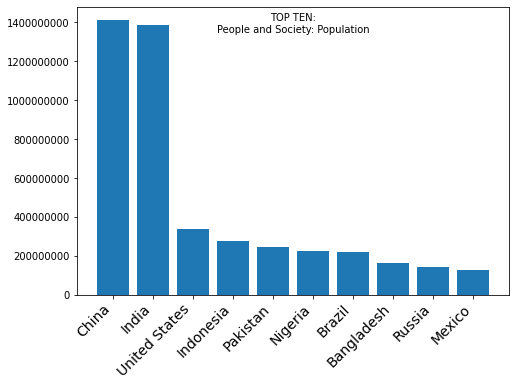

People and Society: Age structure - 0-14 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


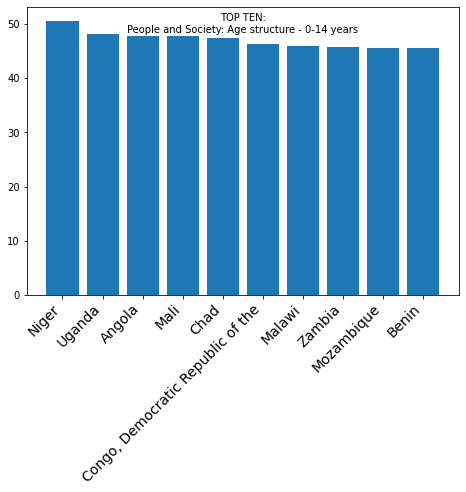

People and Society: Age structure - 15-24 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


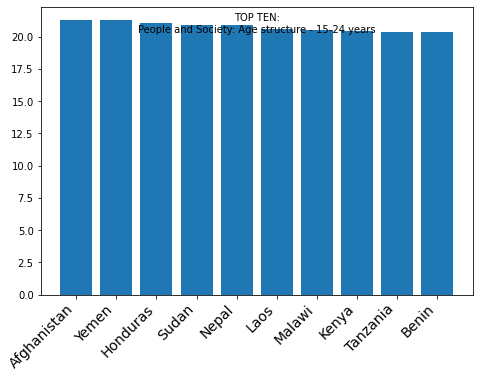

People and Society: Age structure - 25-54 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


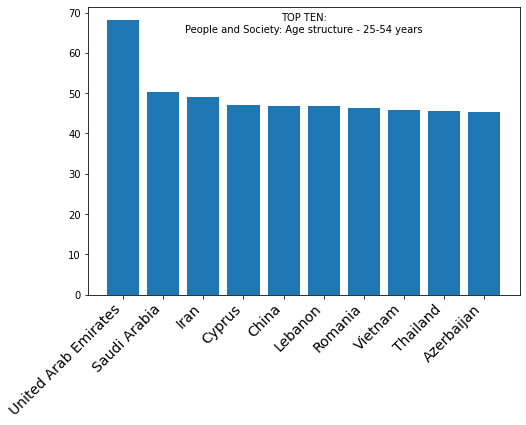

People and Society: Age structure - 55-64 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


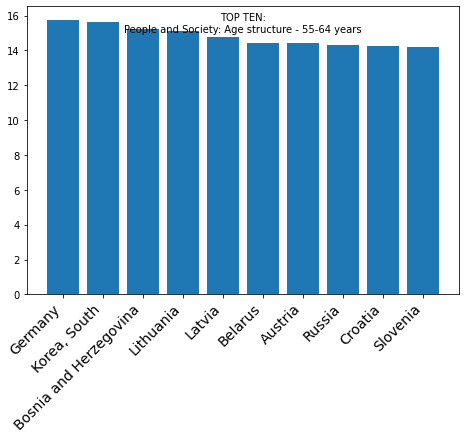

People and Society: Age structure - 65 years and over


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


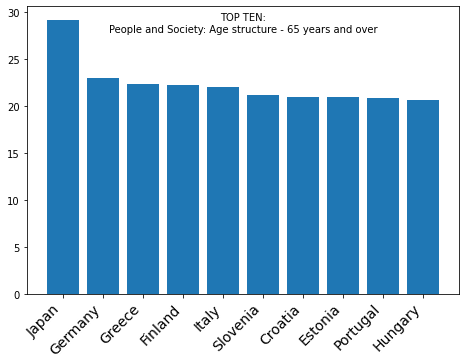

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_9636/675314351.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


People and Society: Dependency ratios - potential support ratio


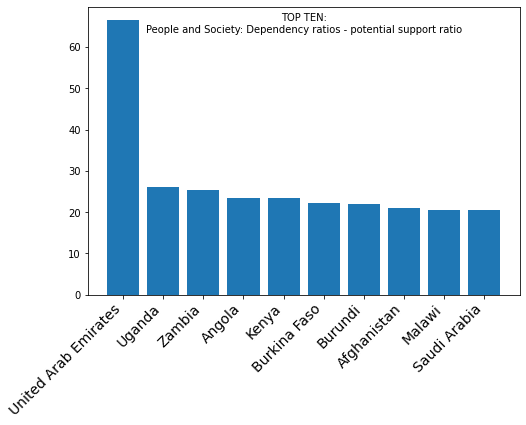

In [66]:
for i in list( df.columns )[ 1:20 ]: showTopTen( i )

# People and Society: Population growth rate / People and Society: Net migration rate
#   Syria booming: - history

# People and Society: Maternal mortality ratio
#   Chad highest by a decent measure: - history

# People and Society: Current Health Expenditure
#   US tops; surprised after hearing how much is copped by private citizens

In [ ]:
# Things that China is in the top-ten/5/3/1 of
# combine bottom-tens somehow?

In [ ]:
# Generate CORRELATION DICTIONARY where keys are correlations,
#   values are key-value pairs of baseCol : compareDict
#   CompareDict key-value is col num : correlation coefficient

# correlDict = { }
# baseCol = 1
# while True:
#     colCorrs = { }
#     for colPos in range( baseCol + 1, df.shape[ 1 ] ):
#         colCorrs[ colPos ] = df.iloc[ :, baseCol ].corr( df.iloc[ :, colPos ] )
#     correlDict[ baseCol ] = colCorrs
#     baseCol += 1
#     if baseCol == df.shape[ 1 ]: print( f"Completed correlations" ); break
# 


In [ ]:
# END